# Import thư viện

In [25]:
# Thư viện cơ bản
import numpy as np
import pandas as pd
import random

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns   

# Thư viện tiền xử lý dữ liệu, tối ưu hóa mô hình
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

# Thư viện xây dựng mô hình
from sklearn.neighbors import KNeighborsClassifier
# Thư viện đánh giá mô hình
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, classification_report, precision_score

df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Potability
0    1998
1    1278
Name: count, dtype: int64

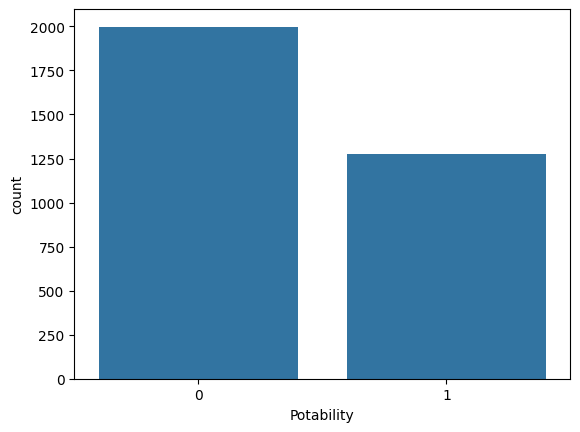

In [6]:
# 0 - Không uống được
# 1 - Uống được
sns.countplot(x = df['Potability'])
df['Potability'].value_counts()

In [8]:
df.shape

(3276, 10)

# Tiền xử lý dữ liệu

# Các bước đã làm ở tiền xử lý dữ liệu:
1. Điền null
* Lí do cần điền null:


* Mô hình sẽ báo lỗi hoặc cho kết quả sai nếu có ô bị null, vì nó không thể học được gì từ ô đó.
* Nếu không điền thì chỉ còn cách xóa cả hàng có chứa ô null, dẫn đến mất dữ liệu.
* Một số phương pháp chuẩn hóa như: MinMaxScaler, StandardScaler, thì null sẽ làm hỏng quá trình scale.

* Phương pháp điền null:


* Do các cột đều có phân phối khá chuẩn (Normal distribution), nên chọn phương pháp điền bằng trung vị (median).
* Các cột có null và % null: pH (~15%), Sulfate (~24%) và Trihalomethanes (~5%).
* Cột Trihalomethanes thiếu ít, nên điền thẳng median vào các cột null.
* Cột pH và Sulfate thiếu tương đối, dù vẫn điền bằng median nhưng gộp theo nhãn (median riêng của nhãn 0 và 1) rồi điền.

2. Xử lý ngoại lai
* Lí do cần xử lý ngoại lai:


* Một vài giá trị cao hoặc quá cao so với bình thường có thể kéo lệch trung bình, phương sai, làm sai các phép tính thống kê.
* Nếu dùng mô hình nhạy cảm với ngoại lai (ví dụ: KNN - tính theo khoảng cách) thì ngoại lai có thể khiến mô hình học sai bản chất.
* Một số phương pháp chuẩn hóa như: MinMaxScaler thì ngoại lai sẽ làm hỏng quá trình scale.

* Phương pháp xử lí ngoại lai:


* Ở đây sử dụng phương pháp 1.5 * IQR (Interquantile range: Khoảng trong phân vị từ 25% - 75%).
* Gán ngưỡng trên và ngưỡng dưới cách Q1 và Q3 1 khoảng bằng 1.5 lần IQR.
* Nếu ngoại lai lớn hơn ngưỡng trên sẽ được ghi đè thành giá trị ở ngưỡng trên, tương tự với ngưỡng dưới.
* Cách này đảm bảo dữ liệu không bị mất như việc xóa hẳn outlier.

In [10]:
# Check duplicate
df.duplicated().sum()

np.int64(0)

In [11]:
print(df.isnull().sum()[df.isnull().sum() > 0])
(df.isnull().sum()[df.isnull().sum() > 0] / len(df) * 100).round(2)


ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64


ph                 14.99
Sulfate            23.84
Trihalomethanes     4.95
dtype: float64

In [12]:
df[df['Potability'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1684.0,7.085378,1.683499,0.000000,6.037723,7.035456,8.155510,14.000000
Hardness,1998.0,196.733292,31.057540,98.452931,177.823265,197.123423,216.120687,304.235912
Solids,1998.0,21777.490788,8543.068788,320.942611,15663.057382,20809.618280,27006.249009,61227.196008
Chloramines,1998.0,7.092175,1.501045,1.683993,6.155640,7.090334,8.066462,12.653362
Sulfate,1510.0,334.564290,36.745549,203.444521,311.264006,333.389426,356.853897,460.107069
Conductivity,1998.0,426.730454,80.047317,181.483754,368.498530,422.229331,480.677198,753.342620
Organic_carbon,1998.0,14.364335,3.334554,4.371899,12.101057,14.293508,16.649485,28.300000
Trihalomethanes,1891.0,66.303555,16.079320,0.738000,55.706530,66.542198,77.277704,120.030077
Turbidity,1998.0,3.965800,0.780282,1.450000,3.444062,3.948076,4.496106,6.739000
Potability,1998.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
df[df['Potability'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
ph,1101.0,7.073783,1.448048,0.227499,6.179312,7.036752,7.933068,13.175402
Hardness,1278.0,195.800744,35.547041,47.432000,174.330531,196.632907,218.003420,323.124000
Solids,1278.0,22383.991018,9101.010208,728.750830,15668.985035,21199.386614,27973.236446,56488.672413
Chloramines,1278.0,7.169338,1.702988,0.352000,6.094134,7.215163,8.199261,13.127000
Sulfate,985.0,332.566990,47.692818,129.000000,300.763772,331.838167,365.941346,481.030642
Conductivity,1278.0,425.383800,82.048446,201.619737,360.939023,420.712729,484.155911,695.369528
Organic_carbon,1278.0,14.160893,3.263907,2.200000,12.033897,14.162809,16.356245,23.604298
Trihalomethanes,1223.0,66.539684,16.327419,8.175876,56.014249,66.678214,77.380975,124.000000
Turbidity,1278.0,3.968328,0.780842,1.492207,3.430909,3.958576,4.509569,6.494249
Potability,1278.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='Trihalomethanes', ylabel='Count'>

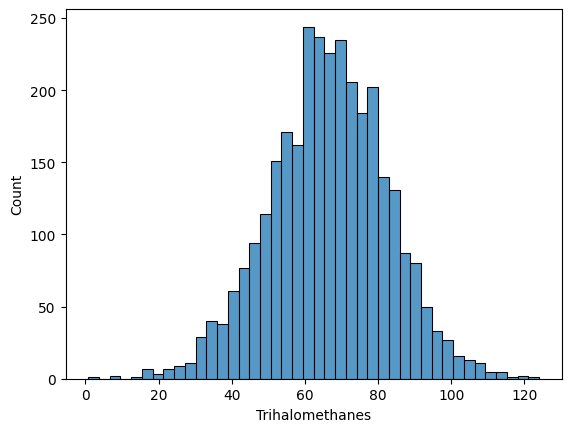

In [14]:
sns.histplot(df['Trihalomethanes'])


<Axes: xlabel='ph', ylabel='Count'>

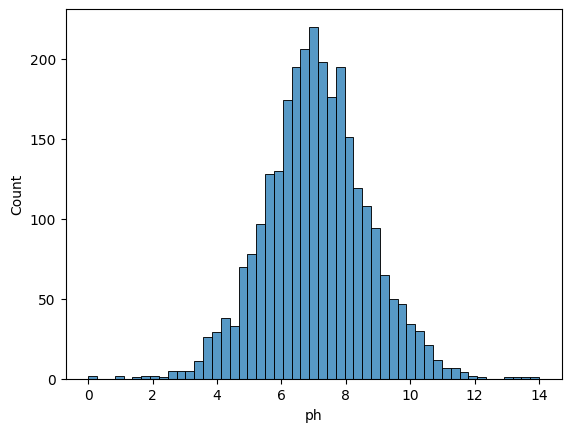

In [15]:
sns.histplot(df['ph'])


<Axes: xlabel='Sulfate', ylabel='Count'>

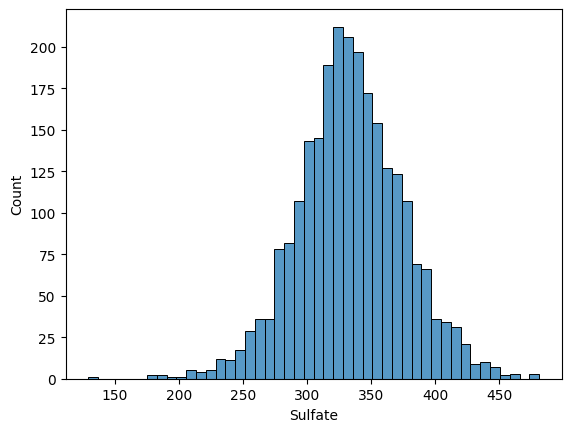

In [16]:
sns.histplot(df['Sulfate'])


* Phân phối gần như chuẩn, chỉ có Sulfate hơi lệch trái


In [18]:
# Xem trung bình, trung vị của 3 cột có giá trị null theo nhãn 0
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].mean()) 
print('\n')
print(df[df['Potability']==0][['ph','Sulfate','Trihalomethanes']].median())

ph                   7.085378
Sulfate            334.564290
Trihalomethanes     66.303555
dtype: float64


ph                   7.035456
Sulfate            333.389426
Trihalomethanes     66.542198
dtype: float64


In [19]:
# Xem trung bình, trung vị của 3 cột có giá trị null theo nhãn 1
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].mean()
print('\n')
df[df['Potability']==1][['ph','Sulfate','Trihalomethanes']].median()

ph                   7.036752
Sulfate            331.838167
Trihalomethanes     66.678214
dtype: float64

# Chia train, test

Chia tập huấn luyện (train) và tập thử nghiệm (test)

* Để mô hình học ở tập train rồi đưa ra phán đoán ở tập test, so sánh sự đúng sai trên so với kết quả của tập test.
* Tập train sẽ chiếm 70% dữ liệu, tập test chiếm 30%.

In [20]:
X = df.drop('Potability', axis=1)
y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# KNN Imputer

In [21]:
cols_to_fill = ['Trihalomethanes', 'ph', 'Sulfate']

In [23]:
X_train_filled = X_train.copy()
X_test_filled = X_test.copy()

for label in [0, 1]:
    # Chỉ số của từng nhóm
    train_idx = y_train[y_train == label].index
    test_idx = y_test[y_test == label].index

    # Fit trên train nhóm đó
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit(X_train.loc[train_idx, cols_to_fill])

    # Transform train
    imputed_train = imputer.transform(X_train.loc[train_idx, cols_to_fill])
    X_train_filled.loc[train_idx, cols_to_fill] = pd.DataFrame(
        imputed_train, columns=cols_to_fill, index=train_idx
    )

    # Transform test
    imputed_test = imputer.transform(X_test.loc[test_idx, cols_to_fill])
    X_test_filled.loc[test_idx, cols_to_fill] = pd.DataFrame(
        imputed_test, columns=cols_to_fill, index=test_idx)

In [24]:
print(X_train_filled.isnull().sum()[X_train.isnull().sum() > 0])
print(X_test_filled.isnull().sum()[X_test_filled.isnull().sum() > 0])

ph                 0
Sulfate            0
Trihalomethanes    0
dtype: int64
Series([], dtype: int64)


# Mô hình KNN 

# Chạy mô hình

In [27]:
random_n = random.randint(1,20)
knn = KNeighborsClassifier(n_neighbors=random_n)
knn.fit(X_train_filled, y_train)


KNeighborsClassifier(n_neighbors=14)

In [29]:
y_pred = knn.predict(X_test_filled)

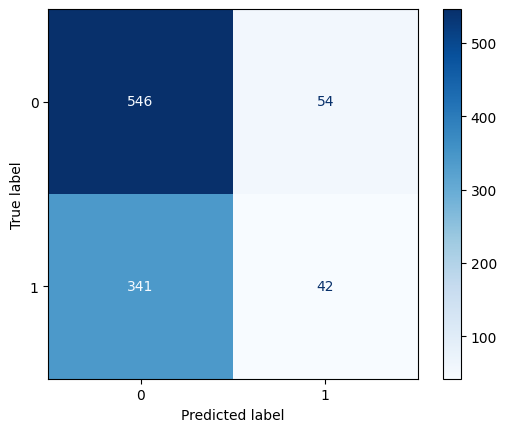

In [30]:
cm = confusion_matrix(y_test, y_pred)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
display_cm.plot(cmap='Blues')

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.91      0.73       600
           1       0.44      0.11      0.18       383

    accuracy                           0.60       983
   macro avg       0.53      0.51      0.45       983
weighted avg       0.55      0.60      0.52       983



# Tối ưu mô hình

In [34]:
# Tối ưu số lượng hàng xóm bằng GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)
grid_search.fit(X_train_filled, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=14), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='precision', verbose=1)

In [35]:
grid_search.best_params_


{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}

In [36]:
best_KNN = grid_search.best_estimator_


In [38]:
y_proba = grid_search.predict_proba(X_test_filled)[:, 1]


In [39]:
# Tạo 1 chuỗi threshold (ngưỡng) từ 0.0 đến 1.0, bước nhảy 0.01
threshold = np.arange(0.0, 1.01, 0.01)

# 1 mảng lưu kết quả từ confusion matrix (ma trận nhầm lẫn)
res = []

for t in threshold:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    res.append((t, fp, fn, tp, tn))

In [40]:
df_thresh = pd.DataFrame(res, columns=['Threshold', 'FP', 'FN', 'TP', 'TN'])
df_thresh['Precision'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FP'])
df_thresh['Recall'] = df_thresh['TP'] / (df_thresh['TP'] + df_thresh['FN'])

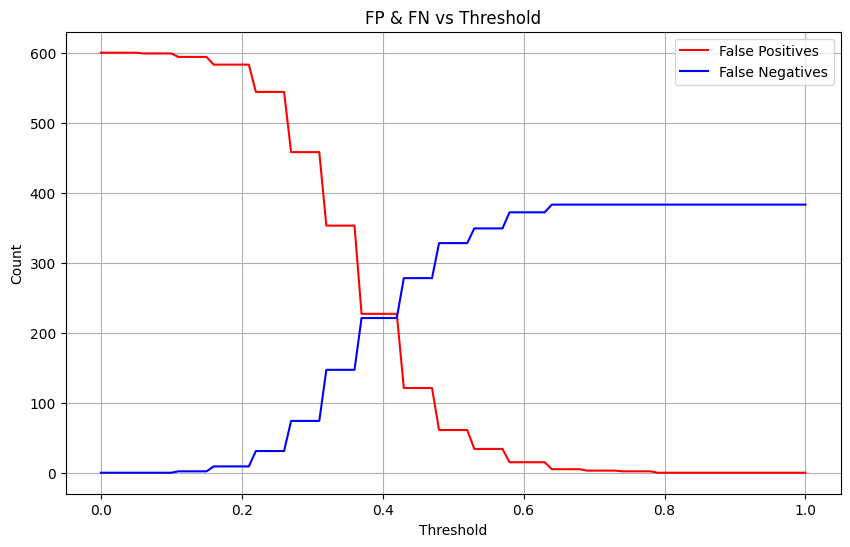

In [41]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh["Threshold"], df_thresh["FP"], label="False Positives", color="red")
plt.plot(df_thresh["Threshold"], df_thresh["FN"], label="False Negatives", color="blue")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title("FP & FN vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ ngưỡng FP và FN theo Threshold

In [43]:
# In ra confusion matrix & classification report theo nhiều threshold khác nhau
for t in threshold:
    print(f"Threshold: {t:.2f}")
    y_pred = (y_proba >= t).astype(int)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Threshold: 0.00
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       600
           1       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro avg       0.19      0.50      0.28       983
weighted avg       0.15      0.39      0.22       983

Threshold: 0.01
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       600
           1       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro avg       0.19      0.50      0.28       983
weighted avg       0.15      0.39      0.22       983

Threshold: 0.02
[[  0 600]
 [  0 383]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       600
           1       0.39      1.00      0.56       383

    accuracy                           0.39       983
   macro av

In [46]:
print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72       617
         1.0       0.53      0.53      0.53       366

    accuracy                           0.65       983
   macro avg       0.62      0.62      0.62       983
weighted avg       0.65      0.65      0.65       983



In [42]:
print(confusion_matrix(y_test, y_pred_best))


[[442 175]
 [171 195]]


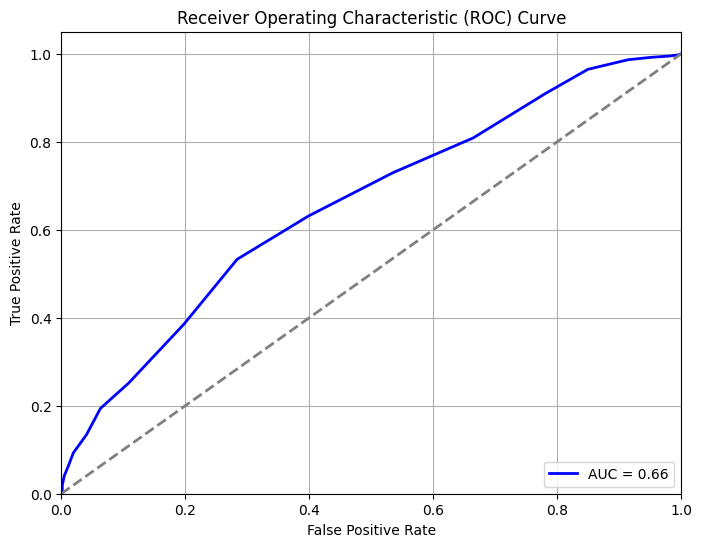

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [44]:
best_knn = grid_search.best_params_
# Hiển thị mô hình đã tối ưu
print("Mô hình KNN tối ưu:")
print(best_knn)

Mô hình KNN tối ưu:
{'metric': 'manhattan', 'n_neighbors': 28, 'weights': 'uniform'}


In [ ]:
# git add .
# git commit -m "Ghi chú"
# git push origin (tên nhánh)